# Práctica 9: Pronósticos con statsmodels
## Gabriela Sánchez Y.

El objetivo en esta práctica es aplicar la librería _statsmodels_ para pronósticos que se puedan realizar con los datos que se han estado estudiando.

En este caso, se ha estado trabajando con datos de incidentes reportados de violencia familiar durante el año 2018 en el estado de Nuevo León. Se intenta predecir el número de incidentes reportados a partir de valores previos obtenidos en distintas escalas de tiempo, algunos ponósticos pueden ser:
- Determinar la cantidad de incidentes de violencia para el mes de diciembre, a partir de los incidentes reportados en los meses de enero a noviembre,
- Determinar el número de incidentes en la cuarta semana del mes de enero a partir de los incidentes reportados durante las primeras tres semanas,

entre otros.

El primer paso es cargar los datos.

In [306]:
import pandas as pd
datos = pd.read_csv("/home/saphira/Desktop/datos/vf_p4.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Meses

Se usa método de Holt para predecir el número de incidentes en el mes de diciembre a partir de los datos de los meses de enero a noviembre.

In [307]:
from collections import Counter

meses = datos.mes
prev = list(filter(lambda dato: dato != 12, meses))
x = Counter([d for d in prev])
a = pd.DataFrame.from_dict(x, orient='index', columns=['no'])
print(cuantos)
#cuantos.plot(kind="line",figsize=(10,5))

1      997
2     1099
3     1372
4     1347
5     1574
6     1595
7     1788
8     1558
9     1563
10    1355
11    1130
Name: no, dtype: int64


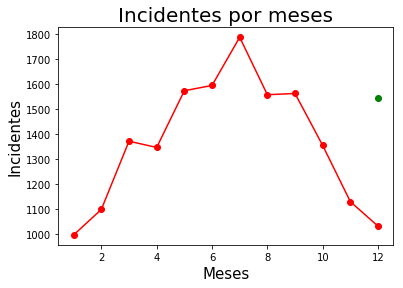

Real 1032
Pronóstico 1545


In [308]:
from numpy import asarray
from statsmodels.tsa.holtwinters import Holt
import matplotlib.pyplot as plt

x = Counter([d for d in meses])
f = Holt(asarray(cuantos)).fit(smoothing_level = 0.1)
plt.title('Incidentes por meses', fontsize = 20)
plt.xlabel('Meses', fontsize = 15)
plt.ylabel('Incidentes', fontsize = 15)
plt.plot([12], f.forecast(1), 'go') # prediccion
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12], x.values(), 'r-o') # enero-dic
plt.show()

print('Real', x[12])
print('Pronóstico', int(f.forecast(1)))

La predicción de Holt (en verde) se aleja del resultado real. Intentar predecir en esta escala de tiempo tal vez no ayuda mucho, se revisa por semanas. No se usan métodos más sofisticados por el tamaño de la serie.

### Semanas

In [309]:
datos.cuantos = 1
d = datos.fecha
d.head()

0    2018/01/01
1    2017/12/27
2    2018/01/01
3    2017/12/22
4    2017/12/25
Name: fecha, dtype: object

Lo primero que se nota y que no se había revisado previamente, es que los datos contienen incidentes reportados en diciembre del año 2017. Para los próximos trabajos, éstos no se consideran. 

Se usan los valores de las primeras 41 semanas y se predicen las últimas 10 del año, esto es, los indicentes de la semana 42 a la 52.

In [313]:
datos.loc[:, 't'] = 1
datos.fecha = pd.to_datetime(pd.Series(datos.fecha))

In [314]:
dates = pd.DataFrame()
dates['fecha'] = datos.fecha
dates.index = dates['fecha']
dates['valor'] = list(datos.t)
dates = dates.loc[dates.fecha.dt.year == 2018]

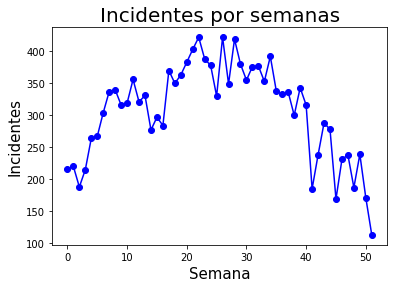

In [315]:
a = dates.groupby(lambda x: x.weekofyear, as_index=False).agg({"valor": "sum"})
plt.title('Incidentes por semanas', fontsize = 20)
plt.xlabel('Semana', fontsize = 15)
plt.ylabel('Incidentes', fontsize = 15)
plt.plot(a.valor, 'b-o')

Reales [238, 288, 278, 169, 231, 238, 187, 239, 171, 113]
Pronóstico [374, 377, 380, 383, 385, 388, 391, 394, 397, 399]


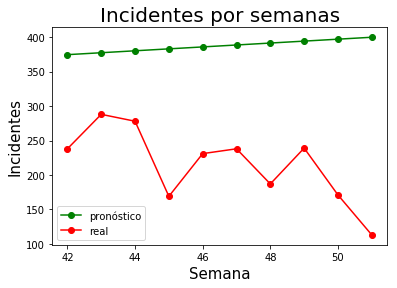

In [316]:
w = []
for i in range(52):
    w.append(i)

f = Holt(asarray(a.valor[0:41])).fit(smoothing_level = 0.1) 
plt.title('Incidentes por semanas', fontsize = 20)
plt.xlabel('Semana', fontsize = 15)
plt.ylabel('Incidentes', fontsize = 15)
plt.plot(w[42:52], f.forecast(10), 'g-o', label = 'pronóstico') # prediccion
plt.plot(w[42:52], a.valor[42:52], 'r-o', label = 'real') # enero-dic
plt.legend(loc='best')

print('Reales', list(a.valor[42:52]))
print('Pronóstico', [int(d) for d in f.forecast(10)])

El pronóstico con el método de Holt no fue bueno, siempre es mayor que el valor real. Nótese que se eligió predecir el número de incidentes a partir de la semana 42, es justo en esta semana donde se presenta un pico en los datos. 

Se intenta entonces, tomar los datos de las primeras 47 semanas para predecir las últimas cinco semanas del año. 

Reales [238, 187, 239, 171, 113]
Pronóstico [305, 306, 307, 307, 308]


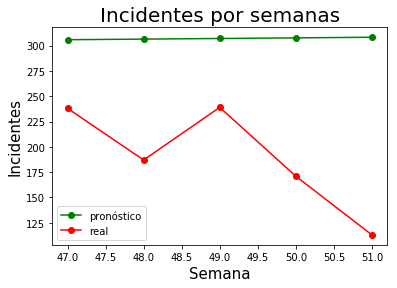

In [317]:
f = Holt(asarray(a.valor[0:46])).fit(smoothing_level = 0.1) 
plt.title('Incidentes por semanas', fontsize = 20)
plt.xlabel('Semana', fontsize = 15)
plt.ylabel('Incidentes', fontsize = 15)
plt.plot(w[47:52], f.forecast(5), 'g-o', label = 'pronóstico') # prediccion
plt.plot(w[47:52], a.valor[47:52], 'r-o', label = 'real') # enero-dic
plt.legend(loc='best')

print('Reales', list(a.valor[47:52]))
print('Pronóstico', [int(d) for d in f.forecast(5)])

Dados los resultados, se prueba la predicción con un método más sofisticado, el modelo ARIMA. El primer paso es revisar que las series de tiempo sean estacionarias.

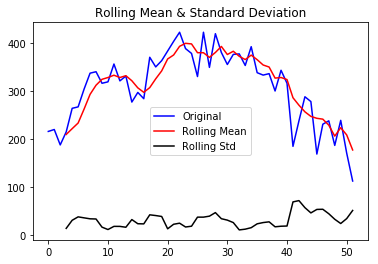

Results of Dickey-Fuller Test:
Test Statistic                 -0.713550
p-value                         0.843208
#Lags Used                      2.000000
Number of Observations Used    49.000000
Critical Value (10%)           -2.599336
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
dtype: float64


In [318]:
from statsmodels.tsa.stattools import adfuller

# rutina de https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
def test_stationarity(ts):
    #Determing rolling statistics
    rolmean = ts.rolling(4).mean()
    rolstd = ts.rolling(4).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(a.valor)

El _estadístico_ es mayor que los valores críticos, por lo que se puede concluir que no se cumple la estacionalidad, además esto se puede notar de la curva roja.

Se siguen las técnicas del [tutorial](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) para lograr la estacionalidad.

De acuerdo con el tutorial, hay dos razones principales por las cuales una serie de tiempo no es estacionaria, una de ellas es ta tendencia, es decir la variación de la media en el tiempo. 

Así, lo primero que se prueba es estimarla y tratar de eliminarla. Uno de los trucos más simples para reducir la tendencia es una diferenciación. Esta técnica toma la diferencia de la observación en un instante particular con la del instante anterior.


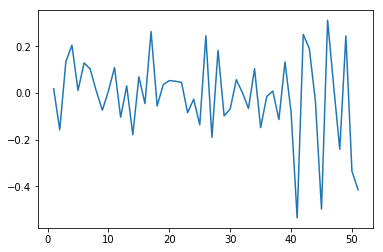

In [319]:
import numpy as np
ts_log = np.log(a.valor)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

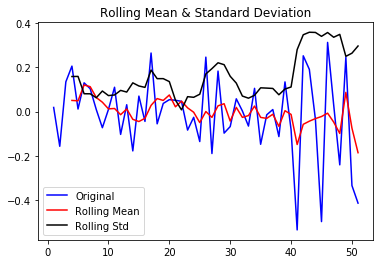

Results of Dickey-Fuller Test:
Test Statistic                -6.822837e+00
p-value                        1.981762e-09
#Lags Used                     1.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (10%)          -2.599336e+00
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
dtype: float64


In [320]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Con esto, aún hay variación en la media y la desviación estándar pero el _estadístico de prueba_ es más pequeño que el 1% de los valores críticos por lo que se puede decir, con un 99% de confianza que se tiene una serie estacionaria. 

Text(0.5, 1.0, 'RSS: 1.3713')

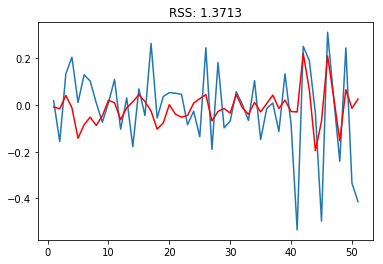

In [321]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RMSE: 199.2029')

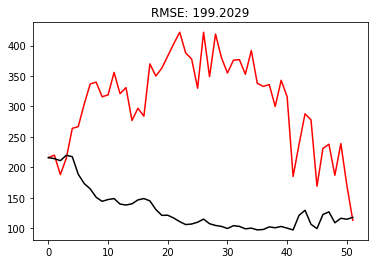

In [322]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(ts_log.loc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(a.valor, 'r')
plt.plot(predictions_ARIMA, 'k')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-a.valor)**2)/len(a.valor)))